Notebook purpose

- Create summary statistics for savings outcome variables

In [1]:
import os
import sys

import linearmodels as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.txn_classifications as tc
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fs = s3fs.S3FileSystem(profile="3di")

In [2]:
df = hd.read_analysis_data()
hd.inspect(df)

Time for read_analysis_data: 3.88 seconds
(163,915, 23)


obs  balance_ca  balance_sa  sa_inflows  sa_outflows  \
user_id date                                                               
57      2012-04-30   66         0.0         NaN         NaN          NaN   
        2012-05-31   75         0.0         NaN         NaN          NaN   

                    sa_net_inflows  sa_scaled_inflows  sa_scaled_outflows  \
user_id date                                                                
57      2012-04-30             NaN                NaN                 NaN   
        2012-05-31             NaN                NaN                 NaN   

                    sa_scaled_net_inflows  total_monthly_spend  \
user_id date                                                     
57      2012-04-30                    NaN             6.784095   
        2012-05-31                    NaN             6.837290   

                    tag_spend_household  tag_spend_hobbies  tag_spend_retail  \
user_id date                                                                   
57      2012-04-30             0.400869           0.011305           0.00937   
        2012-05-31             0.469773           0.010719           0.00000   

                    tag_spend_services  tag_spend_other_spend  \
user_id date                                                    
57      2012-04-30            0.245824               0.067898   
        2012-05-31            0.317825              -0.014239   

                    tag_spend_finance  tag_spend_travel  \
user_id date                                              
57      2012-04-30           0.000837          0.228929   
        2012-05-31           0.001105          0.148343   

                    tag_spend_communication  tag_spend_motor  entropy_sptac  \
user_id date                                                                  
57      2012-04-30                 0.034967              0.0       2.425209   
        2012-05-31                 0.066473              0.0       2.363752   

                    log_income  user_female   age  
user_id date                                       
57      2012-04-30   10.023162          0.0  25.0  
        2012-05-31   10.023162          0.0  25.0

## Savings account inflows

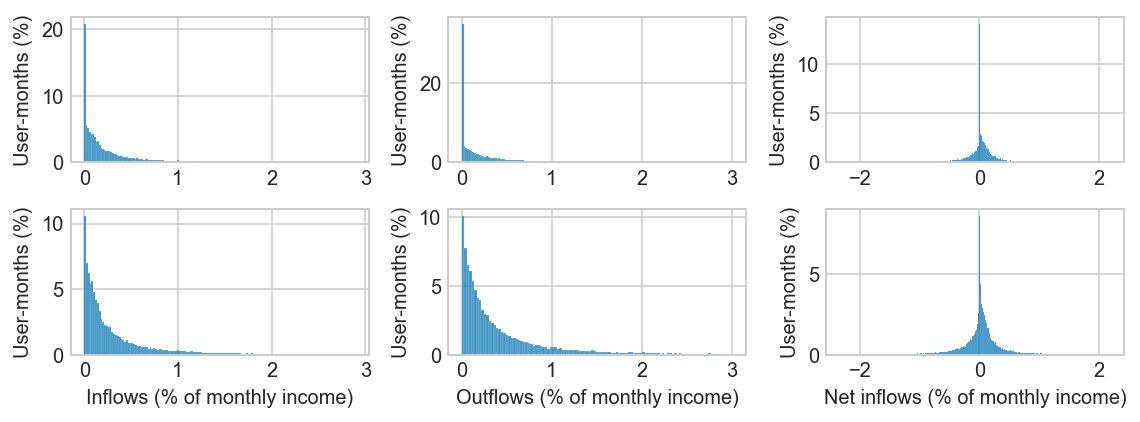

In [47]:
figs.monthly_savings(df);

Text(0.1, -0.1, 'This is one long explanatory note. Like it explains \n a lot of important details about how the figure was\n constructed. And then more.')

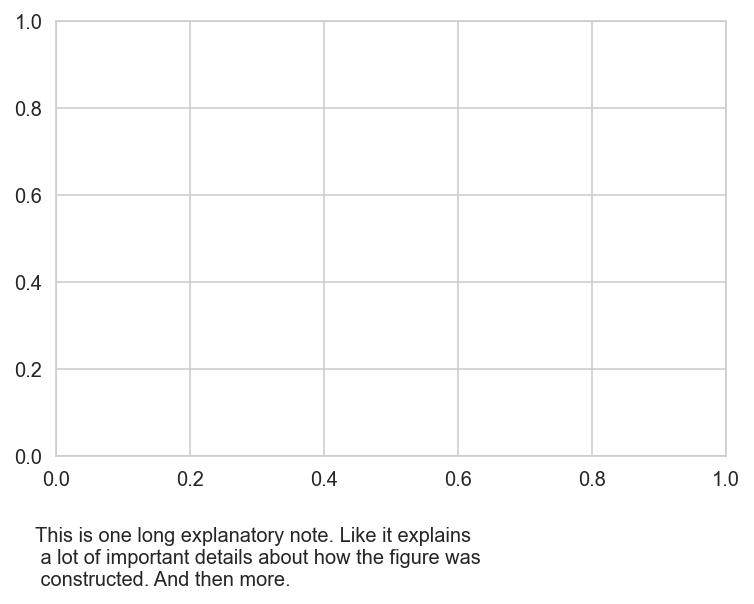

In [12]:
fig, ax = plt.subplots()

note = "This is one long explanatory note. Like it explains \n a lot of important details about how the figure was\n constructed. And then more."

fig.text(0.1, -.1, note, wrap=False)

## Load data

In [2]:
dfs, dfl = hd.read_samples(["777", "XX7"])
hd.inspect(dfl)

Time for read_sample    : 3.08 seconds
Time for read_sample    : 4.46 minutes
(16,074,957, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1088993,2012-04-02,57,23.74,1982 01apr 12 the broadway fruiterer london gb,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-10-23,True,NaN,NaN,NaN,NaN,NaN,u,201204,NaN,22542.600586,2.425209
1,1088994,2012-04-02,57,25.68,1982 01apr 12 waitrose 835 crouch end gb,waitrose,spend,household,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-08-15,True,NaN,waitrose,"food, groceries, household",NaN,supermarket,u,201204,NaN,22542.600586,2.425209


In [3]:
def add_income_pmt(df):
    mask = df.tag_group.eq("income")
    df["income_pmt"] = df.amount.where(mask, np.nan) * -1
    return df


dfl = add_income_pmt(dfl)
dfs = add_income_pmt(dfs)

In [4]:
dfs

,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,income_pmt
0,688300,2012-02-01,777,400.000000,mdbremoved,NaN,transfers,other_transfers,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-11-13,True,364.220001,non merchant mbl,transfers,other account,other account,u,201202,NaN
1,688299,2012-02-01,777,3.030000,aviva pa,aviva,spend,finance,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-08-15,True,364.220001,aviva,health insurance,life insurance,life insurance,u,201202,NaN
2,688301,2012-02-03,777,8.750000,chart ins log tran,NaN,NaN,NaN,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-10-24,True,364.220001,NaN,NaN,memberships,memberships,u,201202,NaN
3,688303,2012-02-03,777,0.990000,9572 02feb 12 apple itunes store gbp london gb,apple,spend,services,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-08-15,True,364.220001,apple,"entertainment, tv, media",NaN,mobile app,u,201202,NaN
4,688302,2012-02-03,777,20.000000,9572 02feb 12 national lottery inte watford gb,camelot,spend,services,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2018-04-30,True,364.220001,camelot,gambling,NaN,gambling,u,201202,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647850,802522114,2020-07-28,587777,-95.000000,mdbremoved bgc,NaN,spend,retail,0.0,w7 3,2020-06-19,NaN,1973.0,2020-06-19,1711781,2020-08-16 18:36:00,barclays,current,2020-07-30,1900-01-01,False,5699.700195,NaN,refunded purchase,NaN,refunded purchase,c,202007,NaN
647851,802887369,2020-07-28,587777,5.400000,tfl travel charge tfl gov uk cp,tfl,spend,travel,0.0,w7 3,2020-06-19,NaN,1973.0,2020-06-19,1711784,2020-08-16 20:35:00,american express,credit card,2020-07-31,1900-01-01,True,-1844.410034,tfl,public transport,NaN,public transport,c,202007,NaN
647852,802887368,2020-07-28,587777,10.650000,marks spencer plc st london,marks and spencer,spend,household,0.0,w7 3,2020-06-19,NaN,1973.0,2020-06-19,1711784,2020-08-16 20:35:00,american express,credit card,2020-07-31,1900-01-01,True,-1844.410034,marks & spencer dept store,"food, groceries, household",NaN,"food, groceries, household",c,202007,NaN
647853,803052582,2020-07-31,587777,3.320000,sanef sa stl 404 ddr,NaN,NaN,NaN,0.0,w7 3,2020-06-19,NaN,1973.0,2020-06-19,1711781,2020-08-16 18:36:00,barclays,current,2020-08-01,1900-01-01,True,5699.700195,NaN,NaN,NaN,NaN,c,202007,NaN


## Timings of income payments and transfers to savings accounts

Income payments per month

In [20]:
def income_pmts_per_month(df):
    df = df.copy()
    return (
        df.groupby(["user_id", "ym"])
        .income_pmt.agg([("txns", "count"), ("income", "sum")])
        .groupby("user_id")
        .agg(
            [
                "mean",
                "median",
                "min",
                "max",
                "std",
                "size",
            ]
        )
    )


income_pmts_per_month(dfl).describe().T

count         mean          std          min          25%  \
txns   mean    5677.0     2.506022     2.073624     0.666667     1.133333   
       median  5677.0     2.426986     2.100056     1.000000     1.000000   
       min     5677.0     1.231108     1.608797     0.000000     0.000000   
       max     5677.0     4.350537     3.355715     1.000000     2.000000   
       std     5677.0     0.861687     0.743961     0.000000     0.432760   
       size    5677.0    28.873525    16.686351     6.000000    15.000000   
income mean    5677.0  2233.210205  1407.756592   292.851654  1316.344727   
       median  5677.0  2176.336670  1347.301147     0.015000  1319.520020   
       min     5677.0   893.116882  1158.431152 -4010.510010     0.000000   
       max     5677.0  4872.775879  5928.009277   425.399994  2171.280029   
       std     5677.0   935.188911  1158.416958     0.000000   323.420319   
       size    5677.0    28.873525    16.686351     6.000000    15.000000   

                       50%          75%           max  
txns   mean       1.921053     3.000000     19.090909  
       median     2.000000     3.000000     19.000000  
       min        1.000000     2.000000     18.000000  
       max        3.000000     5.000000     51.000000  
       std        0.687836     1.090500     11.998607  
       size      25.000000    38.000000    100.000000  
income mean    1872.958130  2728.284668  12378.085938  
       median  1859.750000  2687.479980  14122.665039  
       min      432.000000  1528.780029  10596.169922  
       max     3232.350098  5178.160156  94463.453125  
       std      639.714369  1102.914995  20987.941536  
       size      25.000000    38.000000    100.000000

Number of days between income payments

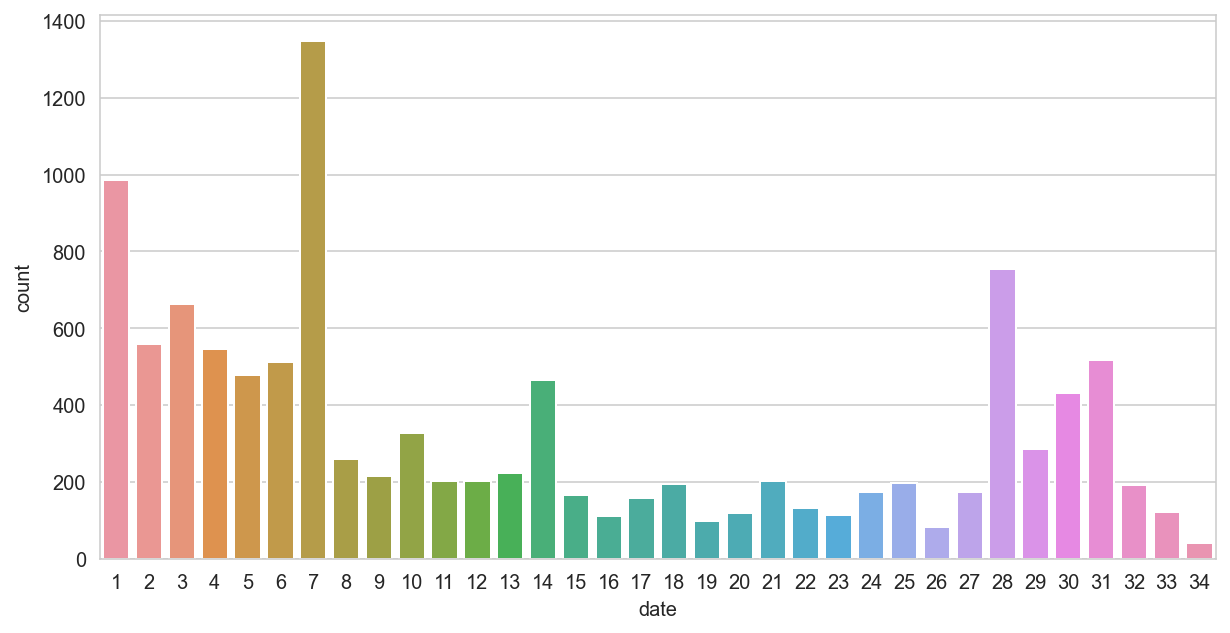

In [146]:
def days_since_last_income_pmt(df):
    def helper(g):
        return g.date.diff().dt.days

    return (
        df.set_index("date")
        .groupby("user_id")
        .resample("d")
        .income_pmt.max()
        .dropna()
        .reset_index()
        .groupby("user_id")
        .apply(helper)
    )


s = (
    days_since_last_income_pmt(dfs)
    .pipe(hd.trim, pct=2.5, how="upper")
    .dropna()
    .astype(int)
)

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x=s);

Number of days between savings account inflows

In [151]:
def diff(df):
    def helper(g):
        return g.date.diff().dt.days

    is_credit = ~df.debit
    is_not_interest_txn = ~df.tag_auto.str.contains("interest", na=False)
    is_savings_account = df.account_type.eq("savings")
    mask = is_credit & is_not_interest_txn & is_savings_account


def days_since_last_income_pmt(df):
    def helper(g):
        return g.date.diff().dt.days

    is_credit = ~df.debit
    is_not_interest_txn = ~df.tag_auto.str.contains("interest", na=False)
    is_savings_account = df.account_type.eq("savings")
    mask = is_credit & is_not_interest_txn & is_savings_account

    return (
        df[mask].set_index("date")
        # .groupby("user_id")
        # .resample("d")
        #         .income_pmt.max()
        #         .dropna()
        #         .reset_index()
        #         .groupby("user_id")
        #         .apply(helper)
    )


s = (
    days_since_last_income_pmt(dfs)
    # .pipe(hd.trim, pct=2.5, how="upper")
    # .dropna()
    # .astype(int)
)

# fig, ax = plt.subplots(figsize=(10, 5))
# sns.countplot(x=s);
s

,id,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,income_pmt
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-04,414297170,777,-480.0,from a c 5781 via mobile xfer,NaN,transfers,other_transfers,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2017-11-10,819747,2019-09-10 13:47:00,natwest bank,savings,2018-06-09,2018-10-08,False,164.690002,personal,transfers,NaN,NaN,u,201806,NaN
2018-07-30,433561934,777,-420.0,from a c 5781 via mobile xfer,NaN,transfers,other_transfers,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2017-11-10,819747,2019-09-10 13:47:00,natwest bank,savings,2018-08-04,2018-10-08,False,164.690002,personal,transfers,NaN,NaN,u,201807,NaN
2018-09-06,449189408,777,-150.0,from a c 5781 via mobile xfer,NaN,transfers,other_transfers,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2017-11-10,819747,2019-09-10 13:47:00,natwest bank,savings,2018-09-12,2018-10-08,False,164.690002,personal,transfers,NaN,NaN,u,201809,NaN
2019-02-11,512170715,777,-120.0,from a c 5781 via mobile xfer,NaN,transfers,other_transfers,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2017-11-10,819747,2019-09-10 13:47:00,natwest bank,savings,2019-02-17,1900-01-01,False,164.690002,personal,transfers,NaN,transfers,c,201902,NaN
2019-02-11,512170716,777,-60.0,from a c 5781 via mobile xfer,NaN,transfers,other_transfers,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2017-11-10,819747,2019-09-10 13:47:00,natwest bank,savings,2019-02-17,1900-01-01,False,164.690002,personal,transfers,NaN,transfers,c,201902,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-28,707360731,570777,-100.0,mdbremoved ft,NaN,NaN,other_transfers,0.0,wa5 8,2020-02-10,NaN,1979.0,2020-02-10,1592399,2020-05-09 17:18:00,barclays,savings,2020-02-11,1900-01-01,False,0.040000,NaN,NaN,NaN,NaN,c,201812,NaN
2019-01-29,707360729,570777,-100.0,mdbremoved ft,NaN,NaN,other_transfers,0.0,wa5 8,2020-02-10,NaN,1979.0,2020-02-10,1592399,2020-05-09 17:18:00,barclays,savings,2020-02-11,1900-01-01,False,0.040000,NaN,NaN,NaN,NaN,c,201901,NaN
2019-03-30,707360724,570777,-80.0,mdbremoved bgc,NaN,transfers,savings,0.0,wa5 8,2020-02-10,NaN,1979.0,2020-02-10,1592399,2020-05-09 17:18:00,barclays,savings,2020-02-11,1900-01-01,False,0.040000,NaN,savings (general),NaN,savings (general),c,201903,NaN


Number of days since last income payment at time of savings account inflow

In [21]:
def f(df):

    return d


f(dfs)

user_id  date      
777      2012-02-01   NaN
         2012-02-02   NaN
         2012-02-03   NaN
         2012-02-04   NaN
         2012-02-05   NaN
                       ..
587777   2020-07-27   NaN
         2020-07-28   NaN
         2020-07-29   NaN
         2020-07-30   NaN
         2020-07-31   NaN
Name: income_pmt, Length: 237894, dtype: float32

In [42]:
def add_days_since_last_income(df):
    def helper(g):
        ones = g.income_pmt.ffill().where(lambda s: s.isna(), 1)
        cumsum = ones.cumsum()
        reset = -cumsum[g.income_pmt.notna()].diff().fillna(cumsum).sub(1)
        g["days_since_last_income"] = ones.where(g.income_pmt.isna(), reset).cumsum()
        return g

    return (
        df.set_index("date")
        .groupby("user_id")
        .resample("d")
        .income_pmt.max()
        .reset_index("user_id")
        .groupby("user_id")
        .apply(helper)
    )


a = add_days_since_last_income(dfs)
a.head()

,user_id,income_pmt,days_since_last_income
date,,,
2012-02-01,777,NaN,NaN
2012-02-02,777,NaN,NaN
2012-02-03,777,NaN,NaN
2012-02-04,777,NaN,NaN
2012-02-05,777,NaN,NaN
